# Морфология 2
В данном ноутбуке находится задание на триграммы и словарь. В качестве текста будем использовать томик войны и мира: https://goo.gl/qcVTLE 

Для начала напомним некоторые полезные инструменты на питоне

## 1. Инструменты

### 1.1. Регулярные выражения
Исчерпывающий пост https://habr.com/ru/post/349860/

In [6]:
import re

# С помощью рег. выражения можно искать, заменять и сентезировать строки по шаблонам
# Парочка простых примеров
numbers = re.findall(r'\d+', r'There is some numbers: 49 and 432')
print(u'Находим числа в строке: ', numbers)

print(u'Простенький токенизатор: ', re.sub('[,\.?!]',' ','How, to? split. text!').split())

print(u'Еще один токенизатор: ', re.split(r'\W+', 'How, to? split. text! Again'))

print(re.sub('[a-z,\.?!]', ' ', 'How do you do, Кирилл?', flags=re.IGNORECASE).split()[0])
# в качестве тренировки придумайте свой токенизатор в случае, когда из текста нужно получить только русские слова.

Находим числа в строке:  ['49', '432']
Простенький токенизатор:  ['How', 'to', 'split', 'text']
Еще один токенизатор:  ['How', 'to', 'split', 'text', 'Again']
Кирилл


### 1.2. Чтение файлов
Чтобы не мучится самим с кодировками, приведем способ чтения файла корпуса.

Чтобы далее работать только со словами русского языка отфильтруем латинские буквы.

In [99]:
import io
import re
wordlilist = None
text_file_path = "wp.txt"
with io.open(text_file_path, "r", encoding='utf-8') as text_file:
    text = text_file.read()
    s_only_letters = re.sub(r'[^\w\s]', ' ', text)
    s_only_rus_letters = re.sub('[a-zA-Z0-9]', ' ', s_only_letters)
    wordlist = [i.lower() for i in s_only_rus_letters.split()]

### 1.3. ООП
В питоне можно создавать свои классы, скорее всего нам понадобится класс для хранения бора

In [8]:
class Node:
    def __init__(self):
        '''
        Simple constructor without params
        '''
        pass
    
    def method(self, par):
        '''
        Simple method with one param
        '''
        pass
    
# все данные хранятся в self, поэтому он и передается первым аргументом во все методы

### 1.4. pyplot
Довольно часто приходится построить какие-нибудт графики и гистограммы для изучения данных, с которыми придется работать. Для этого в питоне есть удобнейший модуль для этого - pyplot. Туториал: https://matplotlib.org/3.1.1/tutorials/introductory/pyplot.html

In [9]:
#!pip install matplotlib # Установка модуля
import matplotlib.pyplot as plt
# команда чтобы картинки рисовались прямо в ноутбуке
%matplotlib inline 

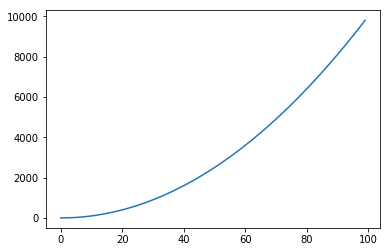

In [10]:
# Посмотрим на график функции x^2
data = [i * i for i in range(100)]
plt.plot(data)

(array([32., 13., 10.,  8.,  8.,  6.,  6.,  6.,  5.,  6.]),
 array([   0. ,  980.1, 1960.2, 2940.3, 3920.4, 4900.5, 5880.6, 6860.7,
        7840.8, 8820.9, 9801. ]),
 <a list of 10 Patch objects>)

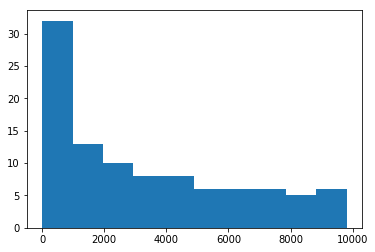

In [11]:
# и распределение по значениям
plt.hist(data)

Также полезная команда для подсчета времения выполнеия в ячейке

In [ ]:
%%time
res = 0
for i in range(int(1e8)):
    res += 1

## 2. Задание
Собственно теперь нам потребуется написать подсчет триграмм и бор для словаря, чтобы реализовать простенькую систему исправления ошибок.

### 2.1. Триграммы
Для начала получим словарь триграмма - её кол-во в тексте, не забывая о начале и конце слова.

Далее можно построить гистограмму на кол-во вхождений триграмм, и посмотреть самые частые и какая частота у каких-нибудь заведомо странных, например: 'чгк', 'шкя' и подобные. Из полученных данных придумать эвристику, как считать слово с опечаткой. Проверить эвристику по словарю.

In [106]:
def split_to_trigrams(word):
    res = []
    if len(word) == 0:
        return res
    word = "##" + word + "##"
    for ind, i in enumerate(word[:-2]):
        key = word[ind:ind+3]
        res.append(key)
    return res

def corpus_trigrams(word_list):
    corpus = {}
    for word in word_list:
        trigrams = split_to_trigrams(word)
        for trigram in trigrams:
            if trigram not in corpus:
                corpus[trigram] = 0
            corpus[trigram] += 1
    return corpus

Построим функию распределения количества триграмм и выберем такое $N$, что суммарное количество триграм, которых встретилось меньше чем $N$ по отдельности, меньше 5% от всего количества триграм.

Number of trigrams 6224


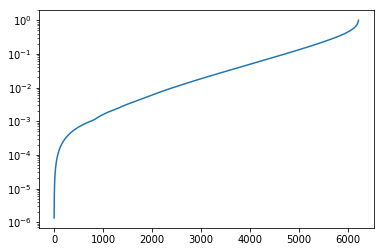

In [145]:
corpus = corpus_trigrams(wordlist)
print(u"Number of trigrams", len(corpus.keys()))
data = [corpus[i] for i in corpus]
data.sort()
alpha_threshold = 0.001
s = float(sum(data))
data_ = []
S = 0
for ind, i in enumerate(data):
    S += i
    data_.append(S/s)
    if S / s <= alpha_threshold:
        N_threshold = data[ind]
_ = plt.plot(data_)
plt.yscale("log")

Отнесем к "ошибочным" гистограммам все слишком редко встречающиеся. В качестве порога, мы выбрали 5%. Как можно увидеть ниже, мы отфильтруем все триграммы, встречающиеся меньше 19 раз.

In [146]:
N_threshold

1

In [147]:
corpus = [i for i in corpus if corpus[i] > N_threshold]

In [148]:
def is_error(word, corpus, return_trigram=True):
    '''is the word with mistake'''
    trigrams = split_to_trigrams(word)
    for i in trigrams:
        if i not in corpus:
            if return_trigram:
                return True, i
            else:
                return True
    if return_trigram:
        return False, ""
    else:
        return False

In [164]:
words = ["привет", "приает", "рекомендация", "жизнь", "жизнб"]
for word in words:
    error = is_error(word, corpus)
    print("Word: %s \t\t is_error:" % word, error)

Word: привет 		 is_error: (False, '')
Word: приает 		 is_error: (True, 'иае')
Word: рекомендация 		 is_error: (True, 'дац')
Word: жизнь 		 is_error: (False, '')
Word: жизнб 		 is_error: (True, 'знб')


### 2.2. Бор
Далее построим бор, с помощью которого будем искать исправления опечатки в слове. Пока только в случае замены и удаления в конце (Если есть желание, то можно и для всех случаев). Также сравнить по времени с поиском в случае замены в исходном слове последних двух символов и поиске в словаре.

In [244]:
def reconstruct(node):
    s = node.letter
    while node.prev is not None:
        s = node.prev.letter + s
        node = node.prev
    return s

In [315]:
class Node:
    def __init__(self, letter):
        self.letter = letter
        self.is_red = False
        self.children = []
        self.prev = None
    
    def add_child(self, child):
        self.children.append(child)
        child.prev = self
    
    def find_word_branch(self, word):
        """
            The additional method for adding word into tree
        """
        ind = 0
        parent = self
        while ind < len(word):
            cur_child = None
            for child in parent.children:
                if child.letter == word[ind]:
                    cur_child = child
                    break
            if cur_child is None:
                return parent, ind
            parent = cur_child
            ind += 1
        return parent, None
    
    def find_nearest_word(self, word, num_errors=0):
        ind = 0
        parent = self
        # Each variant is (current node, current index of letter in word,
        # number of made errors
        possible_variants = [(parent, 0, 0)]
        final_variants = []
        while len(possible_variants) > 0:
            new_possible_variant = []
            while len(possible_variants) > 0:
                variant = possible_variants.pop()
                if variant[2] < num_errors:
                    # Additional Error in Word
                    if variant[1] < len(word):
                        new_variant = (variant[0], variant[1] + 1, variant[2] + 1)
                        new_possible_variant.append(new_variant)
                        for child in variant[0].children:
                            # Skipped Error in word
                            new_variant = (child, variant[1], variant[2] + 1)
                            new_possible_variant.append(new_variant)
                            add_error = word[variant[1]] != child.letter
                            new_variant = (child, variant[1] + 1, variant[2] + int(add_error))
                            new_possible_variant.append(new_variant)
                if variant[2] == num_errors and variant[1] < len(word):
                    for child in variant[0].children:
                        add_error = word[variant[1]] != child.letter
                        if add_error == 0:
                            new_variant = (child, variant[1] + 1, variant[2])
                            new_possible_variant.append(new_variant)
            possible_variants = new_possible_variant
            for variant in possible_variants:
                if variant[0].is_red and variant[1] == len(word):
                    final_variants.append(variant)
        if len(final_variants) == 0:
            return None
        final_variants.sort(key=lambda x: x[-1])
        opt = final_variants[0][0]
        s = opt.letter
        while opt.prev is not None:
            s = opt.prev.letter + s
            opt = opt.prev
        return s

In [316]:
root = Node("")
for word in wordlist:
    child, ind = root.find_word_branch(word)
    if ind is not None:
        node = child
        for i in word[ind:]:
            node1 = Node(i)
            node.add_child(node1)
            node = node1
        node.is_red = True

In [358]:
from nltk.metrics import edit_distance
def correct_word(word):
    '''returns most similar word from dictionary'''
    return root.find_nearest_word(word, 3)

def correct_word_naive(word):
    '''correct word using generation'''
    min_value = None
    correct = None
    for candidate in wordlist:
        cur_dist = edit_distance(candidate, word)
        if min_value is None or cur_dist < min_value:
            min_value = cur_dist
            correct = candidate
        if min_value == 0:
            return correct
    return correct

In [359]:
print("лев -", correct_word("лев"))
print("лив -", correct_word("лив"))

лев - лев
лив - лев


### 2.3 Все вместе
Теперь соберем поиск и исправление опечаток в одну систему, которая будет принимать текст и править его. Также замерим скорость по сравнению с "менее наивным подходом".

In [360]:
def correct_mistakes(text):
    '''returns corrected text'''
    text.split()
    correct_text = []
    for word in text.split():
        correct = correct_word(word)
        if correct is None:
             correct = word
        correct_text.append(correct)
    return " ".join(correct_text)

def correct_mistakes_naive(text):
    '''returns corrected text using generation'''
    text.split()
    correct_text = []
    for word in text.split():
        correct = correct_word_naive(word)
        if correct is None:
             correct = word
        correct_text.append(correct)
    return " ".join(correct_text)

In [361]:
text = "Лев Николаевч Толстов нвписл книгуу Война И Мир"
print("Бор: ", correct_mistakes(text.lower()))
print("Naive: ",correct_mistakes_naive(text.lower()))

Бор:  лев николаевич толстой написал книгу война и мир
Naive:  лев николаевич толстой написал книгу война и мир


Как мы видим выше, обе реализации работают корректно и исправляют опечатки (Толстов), пропуски (Николаевч) и дополнительные буквы (книгуу) и смесь ошибок (нвписл). Сравним эти реализации теперь по времени.

In [362]:
%%time
_ = correct_mistakes(text.lower())

CPU times: user 439 ms, sys: 0 ns, total: 439 ms
Wall time: 438 ms


In [363]:
%%time
_ = correct_mistakes_naive(text.lower())

CPU times: user 13.9 s, sys: 0 ns, total: 13.9 s
Wall time: 13.9 s


Как можно видеть выше, бор работает быстрее более чем в 30 раз, чем наивный подход!